<a href="https://colab.research.google.com/github/yuhui-0611/ESAA/blob/main/ESAA_YB_WEEK12_2_Code_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 및 데이터

[link text](https://www.kaggle.com/code/aryanyadav0950/regression-of-used-car-prices)

# 코드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
train_data = pd.read_csv("/content/drive/MyDrive/ESAA/train_car.csv")
test_data = pd.read_csv("/content/drive/MyDrive/ESAA/test_car.csv")

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [ ]:
train_data.describe

<bound method NDFrame.describe of             id          brand                     model  model_year  milage  \
0            0           MINI             Cooper S Base        2007  213000   
1            1        Lincoln                     LS V8        2002  143250   
2            2      Chevrolet         Silverado 2500 LT        2002  136731   
3            3        Genesis          G90 5.0 Ultimate        2017   19500   
4            4  Mercedes-Benz               Metris Base        2021    7388   
...        ...            ...                       ...         ...     ...   
188528  188528       Cadillac     Escalade ESV Platinum        2017   49000   
188529  188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC        2018   28600   
188530  188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC        2021   13650   
188531  188531           Audi          S5 3.0T Prestige        2022   13895   
188532  188532        Porsche                Macan Base        2016   59500   

            fuel_type                                             engine  \
0            Gasoline       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1            Gasoline       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2       E85 Flex Fuel  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3            Gasoline       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4            Gasoline       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
...               ...                                                ...   
188528       Gasoline       420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel   
188529       Gasoline      385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
188530       Gasoline       469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel   
188531       Gasoline                                               3.0L   
188532       Gasoline       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                          transmission                    ext_col int_col  \
0                                  A/T                     Yellow    Gray   
1                                  A/T                     Silver   Beige   
2                                  A/T                       Blue    Gray   
3       Transmission w/Dual Shift Mode                      Black   Black   
4                          7-Speed A/T                      Black   Beige   
...                                ...                        ...     ...   
188528  Transmission w/Dual Shift Mode                      White   Beige   
188529                     8-Speed A/T                      White   Black   
188530                     7-Speed A/T                      White   Black   
188531               1-Speed Automatic  Daytona Gray Pearl Effect   Black   
188532  Transmission w/Dual Shift Mode                      White   Black   

                                      accident clean_title  price  
0                                None reported         Yes   4200  
1       At least 1 accident or damage reported         Yes   4999  
2                                None reported         Yes  13900  
3                                None reported         Yes  45000  
4                                None reported         Yes  97500  
...                                        ...         ...    ...  
188528                           None reported         Yes  27500  
188529  At least 1 accident or damage reported         Yes  30000  
188530                           None reported         Yes  86900  
188531                           None reported         NaN  84900  
188532                           None reported         Yes  28995  

[188533 rows x 13 columns]>

## Function To Plot Histogram

In [ ]:
def plot_histograms(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

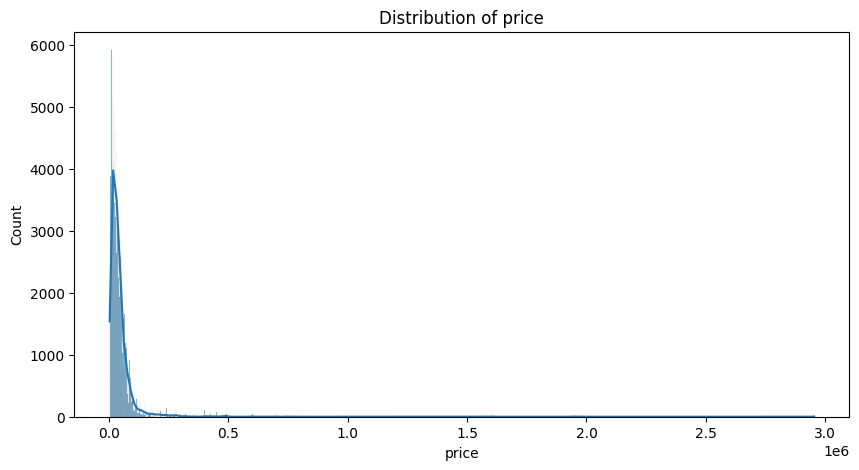

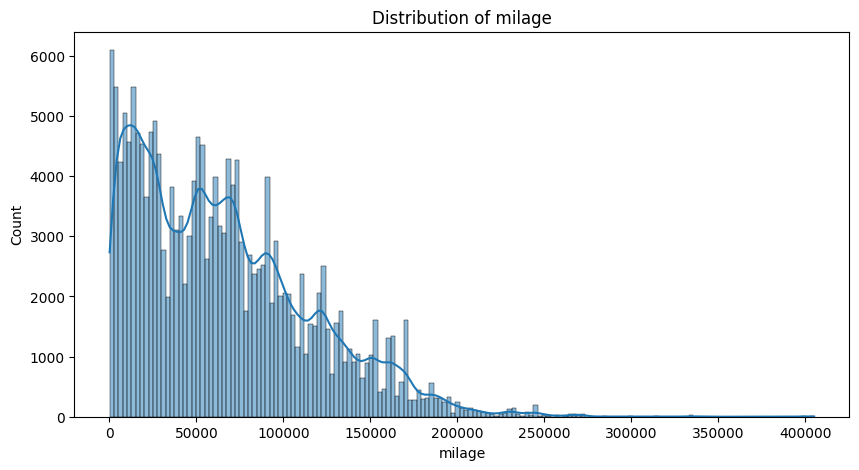

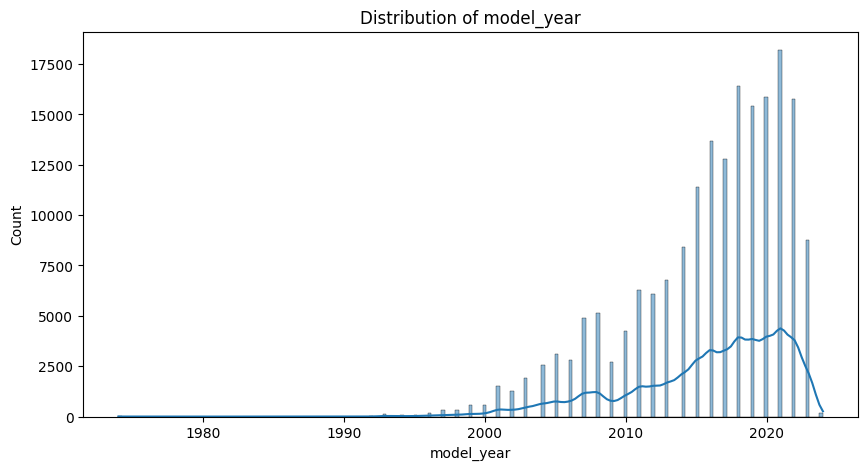

In [ ]:
# Plot histograms for numerical columns
numerical_columns = ['price', 'milage', 'model_year']
plot_histograms(train_data, numerical_columns)

## Log Transform The Target Variable

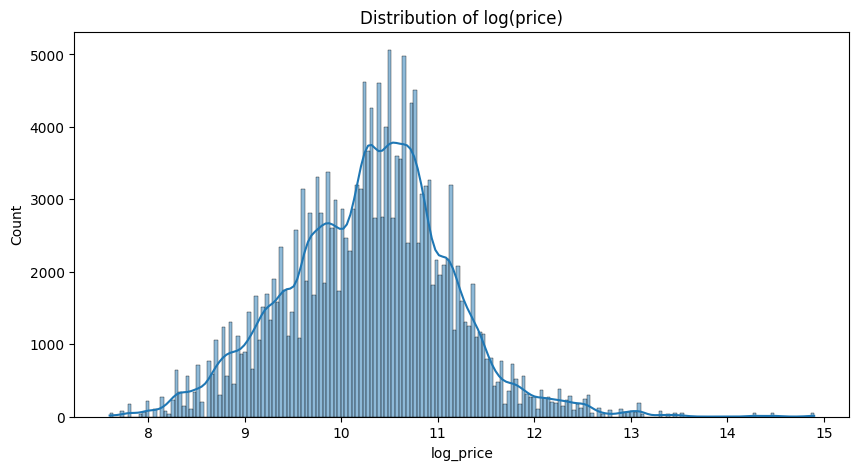

In [ ]:
train_data['log_price'] = np.log(train_data['price'])
plt.figure(figsize=(10, 5))
sns.histplot(train_data['log_price'], kde=True)
plt.title('Distribution of log(price)')
plt.show()

## Prepare feature and target

In [ ]:
X = train_data.drop(['id', 'price', 'log_price'], axis=1)
y = train_data['log_price']
X_test = test_data.drop('id', axis=1)

In [ ]:
# preprocessing steps
numeric_features = ['milage', 'model_year']
categorical_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Create a pipeline with preprocessor and model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['milage', 'model_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [ ]:
# Make predictions
y_pred = model.predict(X_val)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 0.5067226600214778


## Feature Importance

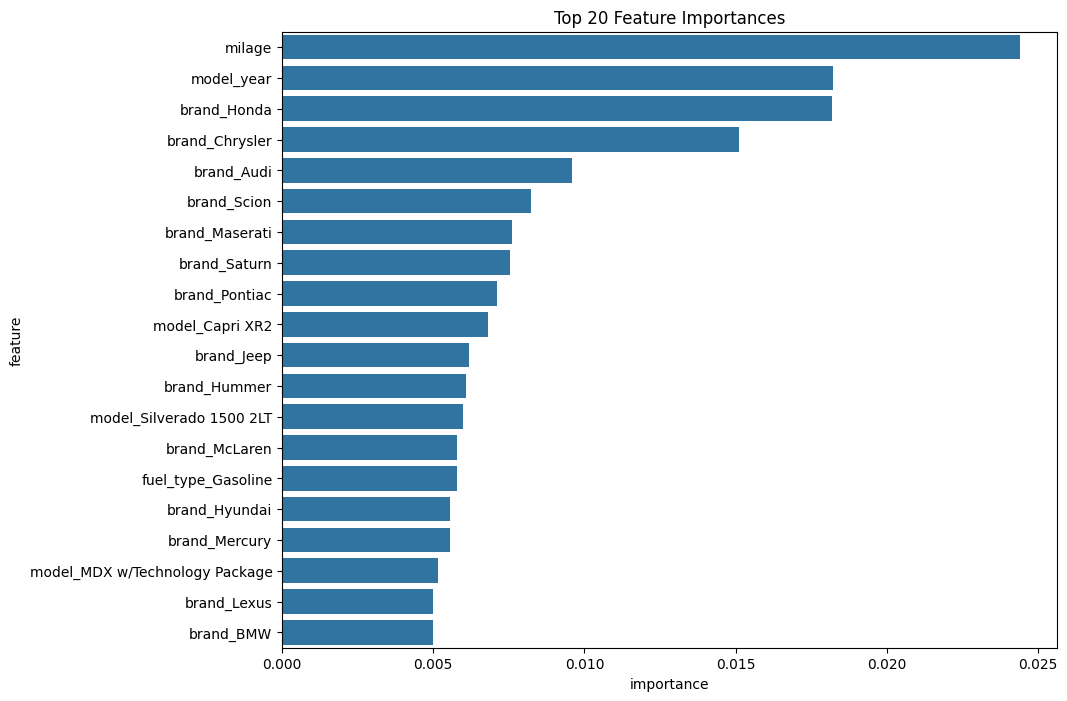

In [ ]:
feature_importance = model.named_steps['regressor'].feature_importances_
feature_names = (numeric_features +
                 [f"{feature}_{category}" for feature in categorical_features
                  for category in X[feature].unique()])

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Top 20 Feature Importances')
plt.show()

In [ ]:
# Make predictions on test set
test_predictions = np.exp(model.predict(X_test))

In [ ]:
test_predictions

array([18228.932 , 60709.645 , 49609.434 , ..., 16478.412 , 12136.9375,
       34735.84  ], dtype=float32)